In [2]:
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy as sp

import utils

In [3]:
# average June-July-August NAO and precipitation from NCEP (since 1950)
data_jja = xr.open_dataset("nao_tp_jja.nc")

In [4]:
data_jja

<xarray.Dataset>
Dimensions:  (year: 70, lat: 94, lon: 192)
Coordinates:
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2015 2016 2017 2018 2019
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    tp       (year, lat, lon) float32 ...
    NAO      (year) float64 ...

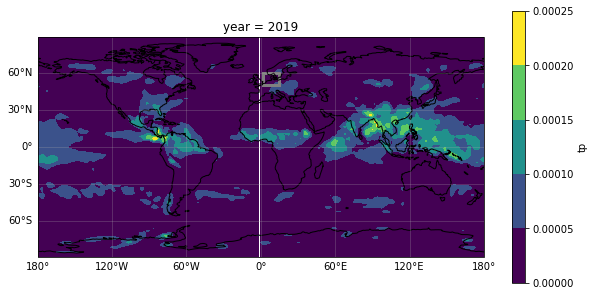

In [5]:
p = utils.plot_dataarray_map(data_jja.sel(year=2019).tp)
utils.add_box('dk', p.axes, color="gray")
plt.show()

In [6]:
#select an area of jja data

area1 = xr.concat((data_jja.sel(lon = slice(280,360), lat = slice(90,20)),data_jja.sel(lon = slice(360,50), lat = slice(90,20))),dim='lon')
area1_precip_mean = area1.tp.mean(dim='year')

Text(0.5, 1.0, 'Multi Year Total Precipitation Mean')

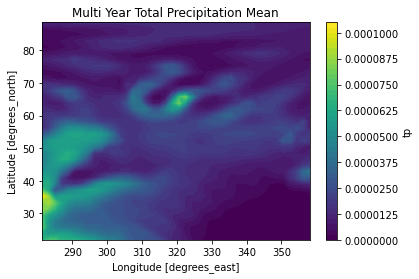

In [7]:
area1_precip_mean.plot.contourf(levels=50)
plt.title('Multi Year Total Precipitation Mean')

**Calculate correlation between NAO and TP in Northern Atlantic/Europe Region**

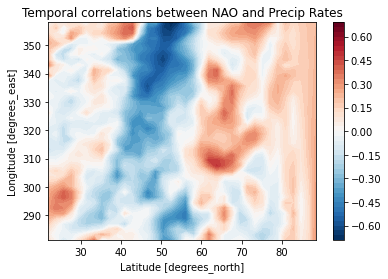

In [8]:
xr.corr(area1.NAO, area1.tp, dim = 'year').plot.contourf(levels=50)
plt.title('Temporal correlations between NAO and Precip Rates')
plt.show()

**Gridbox averages for Denmark and Mediterranian Precipitation**

In [9]:
dk = data_jja.sel(lat = slice(60, 50), lon = slice(2,15))
med = data_jja.sel(lat = slice(41, 36), lon = slice(10,30))
dk_tp_gbmean = dk.tp.mean(dim=('lat','lon'))
med_tp_gbmean = med.tp.mean(dim=('lat','lon'))

In [10]:
#detrend and standardize

dk_tp_gbmean_detrend = xr.apply_ufunc(scipy.signal.detrend , dk_tp_gbmean)
med_tp_gbmean_detrend = xr.apply_ufunc(scipy.signal.detrend , med_tp_gbmean)

dk_tp_gbmean_stdzd = (dk_tp_gbmean_detrend  - dk_tp_gbmean_detrend.mean()) / dk_tp_gbmean_detrend.std()
med_tp_gbmean_stdzd = (med_tp_gbmean_detrend  - med_tp_gbmean_detrend.mean()) / med_tp_gbmean_detrend.std()

**Correlation Relations**

In [11]:
#grid box mean precip correlation between dk and med
print('grid box mean precip correlation between dk and med')
print(xr.corr(dk_tp_gbmean_stdzd, med_tp_gbmean_stdzd).values)

#grid box mean precip correlated with NAO
print('grid box mean precip DK correlated with NAO')
print(xr.corr(dk_tp_gbmean_stdzd, dk.NAO).values)
print('grid box mean precip MED correlated with NAO')
print(xr.corr(med_tp_gbmean_stdzd, med.NAO).values)

#add one NAO.std() to NAO. Which area's correlation is affected more?
#when standardized the correlation coeff equals the slope, so DK would be affected more, as the abs(corr coeff) is higher

grid box mean precip correlation between dk and med
-0.25744708554970086
grid box mean precip DK correlated with NAO
-0.5762253538330392
grid box mean precip MED correlated with NAO
0.4069180445386415


**Remaining Correlation between DK and MED Residuals (=without NAO influence)**

In [12]:
#fitted = a + b * NAO
#residual = original - fitted

fit_paras_med = np.polyfit(data_jja.NAO, med_tp_gbmean_stdzd, 1)
fit_paras_dk = np.polyfit(data_jja.NAO, dk_tp_gbmean_stdzd, 1)
med_fit = fit_paras_med[1] + fit_paras_med[0]*data_jja.NAO
dk_fit = fit_paras_dk[1] + fit_paras_dk[0]*data_jja.NAO

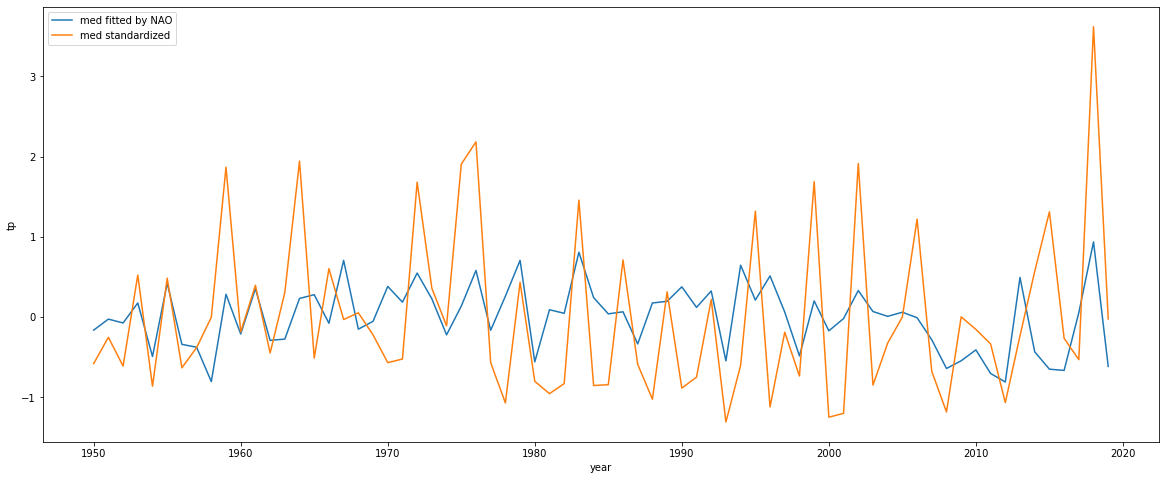

In [13]:
fig = plt.figure(figsize = (20,8))
med_fit.plot(label = 'med fitted by NAO')
med_tp_gbmean_stdzd.plot(label = 'med standardized')
residual_med = med_tp_gbmean_stdzd - med_fit
#residual_med.plot(label = 'residual of med - med fitted')
plt.legend(loc = 0)
plt.show()

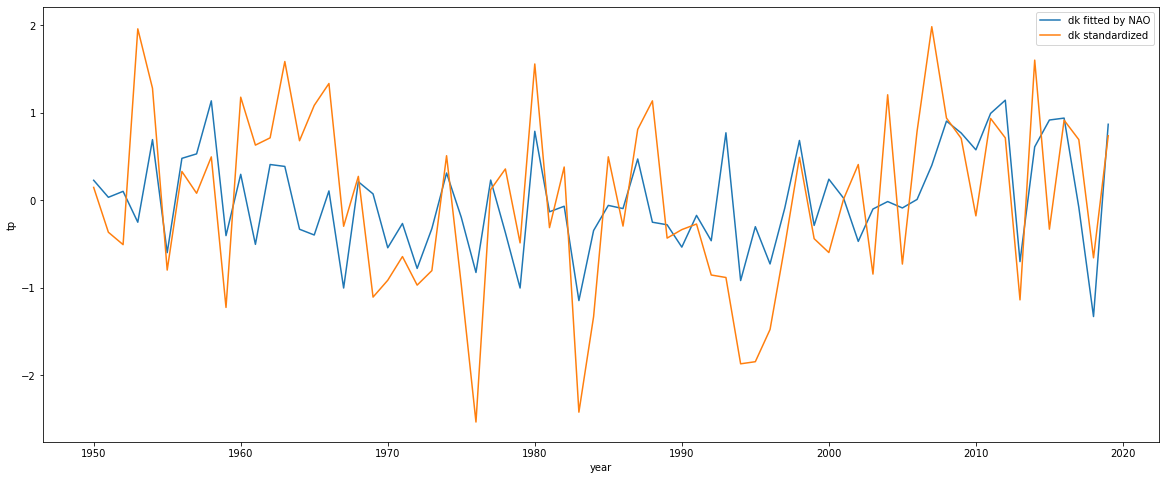

In [14]:
fig = plt.figure(figsize = (20,8))
dk_fit.plot(label = 'dk fitted by NAO')
dk_tp_gbmean_stdzd.plot(label = 'dk standardized')
residual_dk = dk_tp_gbmean_stdzd - dk_fit
#residual_dk.plot(label = 'residual of dk - dk fitted')
plt.legend(loc = 0)
plt.show()

In [15]:
print('grid box mean precip correlation between dk and med')
print(xr.corr(dk_tp_gbmean_stdzd, med_tp_gbmean_stdzd).values)

print('grid box mean precip correlation between dk residual and med residual')
print(xr.corr(residual_dk, residual_med).values)

grid box mean precip correlation between dk and med
-0.25744708554970086
grid box mean precip correlation between dk residual and med residual
-0.030768319814725425


In [16]:
print('r(DK|NAO) * r(MED|NAO)')
print(xr.corr(dk_tp_gbmean_stdzd, data_jja.NAO).values * xr.corr(med_tp_gbmean_stdzd, data_jja.NAO).values)

r(DK|NAO) * r(MED|NAO)
-0.2344764941953271
